In [1]:
# Assignment 2: HDR Imaging and Tonemapping
## Batuhan Yalçın 64274
### April 12, 2023

# Assignment 2: HDR Imaging and Tonemapping
## Batuhan Yalçın 64274
### April 12, 2023

In [1]:
### Connect to my drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Comp427/Assignment2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Comp427/Assignment2


## Imports

In [2]:
import numpy as np
#import OpenEXR
#import Imath
import cv2
import skimage
from skimage import io
import matplotlib.pyplot as plt
import copy

## Some Suggested Hints

In [3]:
#downsamples an input image for some N with I[::N, ::N]
def down_sample(img_path, N = 200):
    I = io.imread(img_path)
    return I[::N, ::N]
## HDR read and write 
def writeHDR(name, data):
    #flip from rgb to bgr for cv2
    cv2.imwrite(name, data[:, :, ::-1].astype(np.float32))
def readHDR(name):
    raw_in = cv2.imread(name, flags=cv2.IMREAD_ANYDEPTH)
    #flip from bgr to rgb
    return raw_in[:, :, ::-1]


## All the functions used in assigment

In [4]:

def read_colorchecker_gm():
    """Returns a 4x6 matrix with sRGB linear values of the Greatg-Macbeth color checker

    function uses L*a*b* data under D50 illumination published by Gretag-Macbeth in 2005 
    (according to http://www.babelcolor.com/main_level/ColorChecker.htm)
    data obtained from  
    Danny Pascale: "RGB coordinates of the Macbeth ColorChecker", page 6
    (available from same webpage)
    the function performs chromatic adaptation from D50 to D65 (sRGB standard illum.) and a conversion from L*a*b* to linear sRGB values

     (c) 200x - 2011; x in {9,10}, Ivo Ihrke
     Universitaet des Saarlandes / MPI Informatik

    L a* b* data CIE D50 illumination for the Gretag Macbeth color checker
    """

    L = [ \
     37.986, \
     65.711, \
     49.927, \
     43.139, \
     55.112, \
     70.719, \
     62.661, \
     40.020, \
     51.124, \
     30.325, \
     72.532, \
     71.941, \
     28.778, \
     55.261, \
     42.101, \
     81.733, \
     51.935, \
     51.038, \
     96.539, \
     81.257, \
     66.766, \
     50.867, \
     35.656, \
     20.461 ]


    a = [ \
     13.555, \
     18.130, \
     -4.880, \
    -13.095, \
      8.844, \
    -33.397, \
     36.067, \
     10.410, \
     48.239, \
     22.976, \
    -23.709, \
     19.363, \
     14.179, \
    -38.342, \
     53.378, \
      4.039, \
     49.986, \
    -28.631, \
     -0.425, \
     -0.638, \
     -0.734, \
     -0.153, \
     -0.421, \
     -0.079  ]  


    b = [ \
     14.059, \
     17.810, \
    -21.925, \
     21.905, \
    -25.399, \
     -0.199, \
     57.096, \
    -45.964, \
     16.248, \
    -21.587, \
     57.255, \
     67.857, \
    -50.297, \
     31.370, \
     28.190, \
     79.819, \
    -14.574, \
    -28.638, \
      1.186, \
     -0.335, \
     -0.504, \
     -0.270, \
     -1.231, \
     -0.973  ]

    L = np.reshape(L, (4, 6))
    a = np.reshape(a, (4, 6))
    b = np.reshape(b, (4, 6))

    Lab = np.zeros((4, 6, 3))
    Lab[:, :, 0] =  L
    Lab[:, :, 1] =  a
    Lab[:, :, 2] =  b

    # compute XYZ
    XYZ = Lab_to_XYZ(Lab, 'D50')

    # compute conversion matrices
    [ M_XYZ_to_RGB, illuminant ] = XYZ_to_RGB_linear( 'sRGB' )

    M = chromatic_adaptation_xyz ( 'D65', illuminant, 'Bradford' )

    # apply conversion matrices
    XYZ = apply_color_matrix( XYZ, M )
    RGB = apply_color_matrix( XYZ, M_XYZ_to_RGB ) # we want linear RGB values for our HDR measurements

    r = RGB[:, :, 0]
    g = RGB[:, :, 1]
    b = RGB[:, :, 2]

    return r, g, b

def Lab_to_XYZ(Lab, illuminant='D65'):
    """(c) Ivo Ihrke 2011
    Universitaet des Saarlandes / MPI Informatik

    convert from L*a*b* (CIELAB) to XYZ color space 
    using one of the CIE standard illuminants

    source:                                                                                                                                                                  
    http://en.wikipedia.org/wiki/Lab_color_space#CIE_XYZ_to_CIE_L.2Aa.2Ab.2A_.28CIELAB.29_and_CIELAB_to_CIE_XYZ_conversions
    2011-01-06

    see also:

    illuminant_xyz
    """
   
    Xn, Yn, Zn = illuminant_xyz(illuminant)

    L = Lab[:, :, 0]
    a = Lab[:, :, 1]
    b = Lab[:, :, 2]
    
    XYZ = np.zeros_like(Lab)
    XYZ[:, :, 0] = Xn * finv( 1/116 * ( L + 16 ) + 1/500 * a )
    XYZ[:, :, 1] = Yn * finv( 1/116 * ( L + 16 ) )
    XYZ[:, :, 2] = Zn * finv( 1/116 * ( L + 16 ) - 1/200 * b )

    return XYZ
    
def finv(val):
    val_out = np.where(val > 6/29, val**3, 3 * (6/29)**2 * ( val - 4/29 ))
    return val_out

def illuminant_xyz(illuminant_in):
    """(c) Ivo Ihrke 2011
     Universitaet des Saarlandes / MPI Informatik

    define xyz coordinates of CIE standard illuminants
    1931 and 1964

    data from 

    http://en.wikipedia.org/wiki/Standard_illuminant



    Name    CIE 1931 2°    CIE 1964 10° CCT (*) in K    Hue Note
        x2       y2     x10     y10
    A   0.44757, 0.40745, 0.45117, 0.40594, 2856            Incandescent / Tungsten
    B   0.34842, 0.35161, 0.34980, 0.35270, 4874            {obsolete} Direct sunlightat noon
    C   0.31006, 0.31616, 0.31039, 0.31905, 6774            {obsolete} Average / North sky Daylight
    D50 0.34567, 0.35850, 0.34773, 0.35952, 5003            Horizon Light. ICC profile PCS
    D55 0.33242, 0.34743, 0.33411, 0.34877, 5503            Mid-morning / Mid-afternoon Daylight
    D65 0.31271, 0.32902, 0.31382, 0.33100, 6504            Noon Daylight: Television, sRGB color space
    D75 0.29902, 0.31485, 0.29968, 0.31740, 7504            North sky Daylight
    E   1/3    , 1/3    , 1/3    , 1/3    , 5454            Equal energy
    F1  0.31310, 0.33727, 0.31811, 0.33559, 6430            Daylight Fluorescent
    F2  0.37208, 0.37529, 0.37925, 0.36733, 4230            Cool White Fluorescent
    F3  0.40910, 0.39430, 0.41761, 0.38324, 3450            White Fluorescent
    F4  0.44018, 0.40329, 0.44920, 0.39074, 2940            Warm White Fluorescent
    F5  0.31379, 0.34531, 0.31975, 0.34246, 6350            Daylight Fluorescent
    F6  0.37790, 0.38835, 0.38660, 0.37847, 4150            Lite White Fluorescent
    F7  0.31292, 0.32933, 0.31569, 0.32960, 6500            D65 simulator, Daylight simulator
    F8  0.34588, 0.35875, 0.34902, 0.35939, 5000            D50 simulator, Sylvania F40 Design 50
    F9  0.37417, 0.37281, 0.37829, 0.37045, 4150            Cool White Deluxe Fluorescent
    F10 0.34609, 0.35986, 0.35090, 0.35444, 5000            Philips TL85, Ultralume 50
    F11 0.38052, 0.37713, 0.38541, 0.37123, 4000            Philips TL84, Ultralume 40
    F12 0.43695, 0.40441, 0.44256, 0.39717, 3000            Philips TL83, Ultralume 30

    (*) CCT= correlated color temperature


    standard is the 1931 definition

    illuinant_in = 'A','B','C', 'D50','D55','D65','D75' etc.

    for 1964 version use 

    illuinant_in = 'A_64','B_64','C_64', 'D50_64','D55_64','D65_64','D75_64' etc.


    verification performed by checking 

    http://brucelindbloom.com/index.html?Eqn_ChromAdapt.html

    """


    ind1931 = np.arange(0, 2)
    ind1964 = np.arange(2, 4)

    illuminants = [ 'A', 'B', 'C', 'D50', 'D55','D65','D75','E','F1', \
                    'F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F11']


    xy = np.array([[0.44757, 0.40745, 0.45117, 0.40594], \
          [0.34842, 0.35161, 0.34980, 0.35270], \
          [0.31006, 0.31616, 0.31039, 0.31905], \
          [0.34567, 0.35850, 0.34773, 0.35952], \
          [0.33242, 0.34743, 0.33411, 0.34877], \
          [0.31271, 0.32902, 0.31382, 0.33100], \
          [0.29902, 0.31485, 0.29968, 0.31740], \
          [1/3    , 1/3    , 1/3    , 1/3    ], \
          [0.31310, 0.33727, 0.31811, 0.33559], \
          [0.37208, 0.37529, 0.37925, 0.36733], \
          [0.40910, 0.39430, 0.41761, 0.38324], \
          [0.44018, 0.40329, 0.44920, 0.39074], \
          [0.31379, 0.34531, 0.31975, 0.34246], \
          [0.37790, 0.38835, 0.38660, 0.37847], \
          [0.31292, 0.32933, 0.31569, 0.32960], \
          [0.34588, 0.35875, 0.34902, 0.35939], \
          [0.37417, 0.37281, 0.37829, 0.37045], \
          [0.34609, 0.35986, 0.35090, 0.35444], \
          [0.38052, 0.37713, 0.38541, 0.37123], \
          [0.43695, 0.40441, 0.44256, 0.39717]])
          
    for i in range(len(illuminants)):
        if illuminants[i] == illuminant_in:
            index_row = i
            index_cols = ind1931

            if len(illuminant_in) > 3:
                if illuminant_in[-3:] == '_64':
                    index_cols = ind1964

            
            data = xy[index_row, index_cols]
            
            X, Y, Z = xyY_to_XYZ(data[0], data[1], 1)
            
    return X, Y, Z

def xyY_to_XYZ(x, y, Y):
    """(c) Ivo Ihrke 2011
    Universitaet des Saarlandes / MPI Informatik
    """

    Xo = Y * x / y
    Yo = Y
    Zo = Y * ( 1 - x - y ) / y
    return Xo, Yo, Zo

def chromatic_adaptation_xyz(from_illum, to_illum, method='Bradford'):

    """
    (c) Ivo Ihrke 2011
        Universitaet des Saarlandes / MPI Informatik

    computes chromatic adaptation matrix for XYZ space
    chromatic adaptation

    input: illuminant names (from, to) and method

           method = 'XYZScaling', 'Bradford', 'vonKries'

           default 'Bradford'

    implementation and choice of default according to 

    http://brucelindbloom.com/index.html?Eqn_ChromAdapt.html

    the conversion matrices given on this webpage seem to  
    use the 'XYZScaling' method which is mentioned as the
    worst choice.
    """

    fX, fY, fZ = illuminant_xyz( from_illum )

    tX, tY, tZ = illuminant_xyz( to_illum )


    # setup Ma (cone response domain transform) according to <method>

    mselected = 0

    if method == 'XYZScaling':
        Ma = np.eye(3)
        mselected = 1

    if method == 'Bradford':
        Ma = np.array([ [0.8951000,  0.2664000, -0.1614000], \
                        [-0.7502000,  1.7135000, 0.0367000], \
                        [0.0389000, -0.0685000,  1.0296000] ])
        mselected = 1


    if method == 'vonKries':
        Ma = np.array([ [0.4002400,  0.7076000, -0.0808100], \
                        [-0.2263000,  1.1653200, 0.0457000], \
                        [0.0000000,  0.0000000,  0.91822000]])
        mselected = 1

    if not mselected:
        # print('chromatic_adaptation_xyz: unknown transform - returning unit matrix');
        M = np.eye(3)
    else:
        # compute transform matrix 

        # rho, gamma, beta
        from_rgb = Ma @ np.array((fX, fY, fZ))

        to_rgb = Ma @ np.array((tX, tY, tZ))

        M = np.linalg.inv(Ma) @ np.diag(to_rgb / from_rgb) @ Ma

    return M


def XYZ_to_RGB_linear(rgb_space='sRGB'):
    """ Data from

    http://brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html

    Name             Gamma   Reference White   Red Primary            Green Primary          Blue Primary        Volume (deltaE^3)         Lab Gamut Efficiency  Coding Efficiency
                                              x      y      Y        x      y      Y        x      y      Y
    Lab Gamut          -         D50           -      -      -        -      -      -        -      -      -        2,381,085                   97.0              35.1
    Adobe RGB (1998) 2.2         D65           0.6400 0.3300 0.297361 0.2100 0.7100 0.627355 0.1500 0.0600 0.075285 1,208,631                   50.6             100.0
    Apple RGB        1.8         D65           0.6250 0.3400 0.244634 0.2800 0.5950 0.672034 0.1550 0.0700 0.083332   798,403                   33.5             100.0
    Best RGB         2.2         D50           0.7347 0.2653 0.228457 0.2150 0.7750 0.737352 0.1300 0.0350 0.034191 2,050,725                   77.6              96.5
    Beta RGB         2.2         D50           0.6888 0.3112 0.303273 0.1986 0.7551 0.663786 0.1265 0.0352 0.032941 1,717,450                   69.3              99.0
    Bruce RGB        2.2         D65           0.6400 0.3300 0.240995 0.2800 0.6500 0.683554 0.1500 0.0600 0.075452   988,939                   41.5             100.0
    CIE RGB          2.2         E             0.7350 0.2650 0.176204 0.2740 0.7170 0.812985 0.1670 0.0090 0.010811 1,725,261                   64.3              96.1
    ColorMatch RGB   1.8         D50           0.6300 0.3400 0.274884 0.2950 0.6050 0.658132 0.1500 0.0750 0.066985   836,975                   35.2             100.0
    Don RGB 4        2.2         D50           0.6960 0.3000 0.278350 0.2150 0.7650 0.687970 0.1300 0.0350 0.033680 1,802,358                   72.1              98.8
    ECI RGB v2        L*         D50           0.6700 0.3300 0.320250 0.2100 0.7100 0.602071 0.1400 0.0800 0.077679 1,331,362                   55.3              99.7
    Ekta Space PS5   2.2         D50           0.6950 0.3050 0.260629 0.2600 0.7000 0.734946 0.1100 0.0050 0.004425 1,623,899                   65.7              99.5
    NTSC RGB         2.2         C             0.6700 0.3300 0.298839 0.2100 0.7100 0.586811 0.1400 0.0800 0.114350 1,300,252                   54.2              99.9
    PAL/SECAM RGB    2.2         D65           0.6400 0.3300 0.222021 0.2900 0.6000 0.706645 0.1500 0.0600 0.071334   849,831                   35.7             100.0
    ProPhoto RGB     1.8         D50           0.7347 0.2653 0.288040 0.1596 0.8404 0.711874 0.0366 0.0001 0.000086 2,879,568                   91.2              87.3
    SMPTE-C RGB      2.2         D65           0.6300 0.3400 0.212395 0.3100 0.5950 0.701049 0.1550 0.0700 0.086556   758,857                   31.9             100.0
    sRGB            #2.2         D65           0.6400 0.3300 0.212656 0.3000 0.6000 0.715158 0.1500 0.0600 0.072186   832,870                   35.0             100.0
    Wide Gamut RGB   2.2         D50           0.7350 0.2650 0.258187 0.1150 0.8260 0.724938 0.1570 0.0180 0.016875 2,164,221                   77.6              91.9


    #2.2 - actual transform is more complex (see http://brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html )

    deltaE^3 is the volume of the gamut in Lab space
    Coding efficiency is the amount of the gamut inside the horseshoe diagram

    implementation verified with Bruce Lindbloom's data
    """

    color_spaces = [ 'Adobe RGB (1998)', 'Apple RGB', 'Best RGB', 'Beta RGB', 'Bruce RGB','CIE RGB', \
                     'ColorMatch RGB','Don RGB 4','ECI RGB v2','Ekta Space PS5','NTSC RGB','PAL/SECAM RGB','ProPhoto RGB','SMPTE-C RGB','sRGB','Wide Gamut RGB']


    reference_whites = [ 'D65', 'D65','D50','D50','D65','E','D50','D50','D50','D50','C','D65','D50','D65','D65','D50' ]

    xyY_red = np.array([[ 0.6400, 0.3300, 0.297361], \
                         [0.6250, 0.3400, 0.244634], \
                         [0.7347, 0.2653, 0.228457], \
                         [0.6888, 0.3112, 0.303273], \
                         [0.6400, 0.3300, 0.240995], \
                         [0.7350, 0.2650, 0.176204], \
                         [0.6300, 0.3400, 0.274884], \
                         [0.6960, 0.3000, 0.278350], \
                         [0.6700, 0.3300, 0.320250], \
                         [0.6950, 0.3050, 0.260629], \
                         [0.6700, 0.3300, 0.298839], \
                         [0.6400, 0.3300, 0.222021], \
                         [0.7347, 0.2653, 0.288040], \
                         [0.6300, 0.3400, 0.212395], \
                         [0.6400, 0.3300, 0.212656], \
                         [0.7350, 0.2650, 0.258187]])

    xyY_green = np.array([[0.2100, 0.7100, 0.627355], \
                          [0.2800, 0.5950, 0.672034], \
                          [0.2150, 0.7750, 0.737352], \
                          [0.1986, 0.7551, 0.663786], \
                          [0.2800, 0.6500, 0.683554], \
                          [0.2740, 0.7170, 0.812985], \
                          [0.2950, 0.6050, 0.658132], \
                          [0.2150, 0.7650, 0.687970], \
                          [0.2100, 0.7100, 0.602071], \
                          [0.2600, 0.7000, 0.734946], \
                          [0.2100, 0.7100, 0.586811], \
                          [0.2900, 0.6000, 0.706645], \
                          [0.1596, 0.8404, 0.711874], \
                          [0.3100, 0.5950, 0.701049], \
                          [0.3000, 0.6000, 0.715158], \
                          [0.1150, 0.8260, 0.724938]])

    xyY_blue = np.array([[0.1500, 0.0600, 0.075285], \
                         [0.1550, 0.0700, 0.083332], \
                         [0.1300, 0.0350, 0.034191], \
                         [0.1265, 0.0352, 0.032941], \
                         [0.1500, 0.0600, 0.075452], \
                         [0.1670, 0.0090, 0.010811], \
                         [0.1500, 0.0750, 0.066985], \
                         [0.1300, 0.0350, 0.033680], \
                         [0.1400, 0.0800, 0.077679], \
                         [0.1100, 0.0050, 0.004425], \
                         [0.1400, 0.0800, 0.114350], \
                         [0.1500, 0.0600, 0.071334], \
                         [0.0366, 0.0001, 0.000086], \
                         [0.1550, 0.0700, 0.086556], \
                         [0.1500, 0.0600, 0.072186], \
                         [0.1570, 0.0180, 0.016875 ]])


    for i in range(len(color_spaces)):
        if color_spaces[i] == rgb_space:            
            index_row = i

    Xr, Yr, Zr = xyY_to_XYZ( xyY_red[index_row, 0], xyY_red[index_row, 1], xyY_red[index_row, 2] )
    Xg, Yg, Zg = xyY_to_XYZ( xyY_green[index_row, 0], xyY_green[index_row, 1], xyY_green[index_row, 2] )
    Xb, Yb, Zb = xyY_to_XYZ( xyY_blue[index_row, 0], xyY_blue[index_row, 1], xyY_blue[index_row, 2] )


    illuminant = reference_whites[index_row]

    Xw, Yw, Zw = illuminant_xyz(illuminant)

    S = np.linalg.inv( np.array([[Xr, Xg, Xb], [Yr, Yg, Yb], [Zr, Zg, Zb]]) ) @ np.array([Xw, Yw, Zw])

    # this matrix is RGB to XYZ
    M = np.array([ [S[0]*Xr, S[1]*Xg, S[2]*Xb], [S[0]*Yr, S[1]*Yg, S[2]*Yb], [S[0]*Zr, S[1]*Zg, S[2]*Zb]])

    M = np.linalg.inv(M)

    return M, illuminant 

def apply_color_matrix(I, matrix):
    """ Applies a 3x3 color matrix to a 3-channel image I

    (c) 2011 Ivo Ihrke
    Universitaet des Saarlandes 
    MPI Informatik
    """
    
    vec = np.reshape(I, (I.shape[0]*I.shape[1], 3))
    out_vec = matrix @ vec.T
    out = np.reshape(out_vec.T, (I.shape[0], I.shape[1], 3))
    return out


def lRGB2XYZ(lRGB):
    """ linear RGB to XYZ
    """
    invM = XYZ_to_RGB_linear('sRGB')[0]
    M = np.linalg.inv(invM)

    # linear rgb
    R = lRGB[:,:,0]
    G = lRGB[:,:,1]
    B = lRGB[:,:,2]

    # through matrix to XYZ
    X = M[0,0] * R + M[0,1] * G + M[0,2] * B
    Y = M[1,0] * R + M[1,1] * G + M[1,2] * B
    Z = M[2,0] * R + M[2,1] * G + M[2,2] * B
    
    XYZ = np.dstack((X, Y, Z))
    return XYZ

def XYZ2lRGB(XYZ):
    """ XYZ to linear RGB
    """

    invM = XYZ_to_RGB_linear('sRGB')[0]

    # XYZ
    X = XYZ[:,:,0]
    Y = XYZ[:,:,1]
    Z = XYZ[:,:,2]

    # through matrix to lRGB
    R = invM[0,0] * X + invM[0,1] * Y + invM[0,2] * Z
    G = invM[1,0] * X + invM[1,1] * Y + invM[1,2] * Z
    B = invM[2,0] * X + invM[2,1] * Y + invM[2,2] * Z

    RGB = np.dstack((R, G, B))
    return RGB

def writeHDR(name, data):
    #flip from rgb to bgr for cv2
    cv2.imwrite(name, data[:, :, ::-1].astype(np.float32))
        
def readHDR(name):
    raw_in = cv2.imread(name, flags=cv2.IMREAD_ANYDEPTH)
    #flip from bgr to rgb
    return raw_in[:, :, ::-1]

def get_matrix_and_vector(method):
    A = np.zeros((0,0))
    b = np.zeros((0,0))
    # A matrix value from images
    for k in range(16):
        image = "./door_stack/exposure" + str(k + 1) + ".jpg"
        # As suggested select N points for optimization
        pixels = down_sample(image)
        # get exposure time for this img shutter speed is 1/2048
        exposure = (1 / 2048) * np.exp2(k)
        # Filter points
        mask_uppers = np.where(pixels > 255)
        mask_lowers = np.where(pixels < 0)
        pixels[mask_uppers] = 255
        pixels[mask_lowers] = 0
        # single g for all the channels
        pixels = np.reshape(pixels, (-1, 1))
       
        # Weights
        if (method == "gaus"):
            weights = np.exp(-4 * (pixels / 255 - 0.5)**2 / (0.5)**2) * 255
        elif (method == "tent"):
            weights = np.minimum(pixels, 255 - pixels)
        elif (method == "uniform"):
            weights = np.ones(pixels.shape) * 255
        else:
            weights = np.ones(pixels.shape) * exposure * 255
        # We should Again filter the weights to zero of bad points
        mask_uppers = np.where(weights > 255)
        mask_lowers = np.where(weights < 0)
        weights[mask_uppers] = 0
        weights[mask_lowers] = 0

        A_matrix = np.zeros((0,0))
        b_vector = []
        for index in range(pixels.shape[0]):
            # A Matrix
            color_row = np.zeros((1,256))
            color_row[0, pixels[index, 0]] = weights[index, 0]
            radiance_row = np.zeros((1, pixels.shape[0]))
            radiance_row[0, index] = -weights[index, 0]
            pixel_row = np.hstack((color_row, radiance_row))
            if A_matrix.shape[0] == 0:
                A_matrix = pixel_row
            else:
                A_matrix = np.vstack((A_matrix, pixel_row))
            # b vector
            b_entry = weights[index, 0] * np.log(exposure)
            b_vector.append(b_entry)
        b_vector = np.asarray(b_vector)
        b_vector = np.reshape(b_vector, (-1, 1))
        
        # Shape Fix
        if A.shape[0] == 0:
            A = A_matrix
            b = b_vector
        else:
            A = np.vstack((A, A_matrix))
            b = np.vstack((b, b_vector))
    return A, b


def get_linearize(method):
    A, b= get_matrix_and_vector(method)
    # A matrix value from smooth regularization
    laplac = np.zeros((254, A.shape[1]))
    b_sub = np.zeros((254, 1))
    lambd = 10
    for i in range(254):
        #Laplacian Submatrix
        at = i + 1
        if (method == "gaus"):
          laplac[i, at] = -2 * lambd * gaussian_weights(at,True)
          laplac[i, at - 1] = lambd * gaussian_weights(at,True)
          laplac[i, at + 1] = lambd * gaussian_weights(at,True)
        elif (method == "tent"):
          laplac[i, at] = -2 * lambd * tent_weights(at,True)
          laplac[i, at - 1] = lambd * tent_weights(at,True)
          laplac[i, at + 1] = lambd * tent_weights(at,True)
        elif (method == "uniform"):
          laplac[i, at] = -2 * lambd * uniform_weights(at,True)
          laplac[i, at - 1] = lambd * uniform_weights(at,True)
          laplac[i, at + 1] = lambd * uniform_weights(at,True)
        else:
          laplac[i, at] = -2 * lambd * photon_weights(at,True,0)
          laplac[i, at - 1] = lambd * photon_weights(at,True,0)
          laplac[i, at + 1] = lambd * photon_weights(at,True,0)


    # A Matrix
    A = np.vstack((A, np.ones((1, A.shape[1])), laplac))
    # b vector
    b = np.vstack((b, np.array([[1]]), b_sub))
    b =b\
    # g function
    g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)
    return g_func




# Function to assign tent weights to pixels
def tent_weights(pixels,is_linear):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.minimum(pixels, 255 - pixels)
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights = np.minimum(pixels, 1 - pixels)
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return min(pixels, 255 - pixels)
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return min(pixels, 1 - pixels)

# Function to assign Gaussian weights to pixels
def gaussian_weights(pixels,is_linear):
  """
  Assigns Gaussian weights to pixels based on their intensity values.
  """
  if isinstance(pixels, np.ndarray):
    if (is_linear):
      weights = np.exp(-4 * (pixels / 255 - 0.5)**2 / (0.5)**2) * 255
      mask_lowers = np.where(pixels < 0)
      mask_uppers = np.where(pixels > 255)
    else:
      weights = np.exp(-4 * (pixels / 1 - 0.5)**2 / (0.5)**2) * 1
      mask_lowers = np.where(pixels < 0.05)
      mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
    return weights
  else:
    if (is_linear):
      if pixels < 0 or pixels > 255:
        return 0
      else:
        return np.exp(-4 * (pixels / 255 - 0.5)**2 / (0.5)**2) * 255
    else:
      if pixels < 0.05 or pixels > 0.95:
        return 0
      else:
        return np.exp(-4 * (pixels / 1 - 0.5)**2 / (0.5)**2) * 1

# Function to assign uniform weights to pixels
def uniform_weights(pixels,is_linear):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.ones(pixels.shape) * 255
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights = np.ones(pixels.shape)
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return 255
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return 1      

# Function to assign Photon weights to pixels
def photon_weights(pixels,is_linear,exposure):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.ones(pixels.shape) * exposure * 255
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights =  np.ones(pixels.shape) * exposure * 1
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return 255
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return 1    

def mrg_to_hdr(is_linear,method,picture_type,weight_function):
  num = 0
  denom = 0
  if picture_type == ".tiff":
    #'2^16-1
    normalize_factor=65535
  if picture_type == ".jpg":
    normalize_factor=255
  for k in range(16):
      ldr_image=io.imread("./door_stack/exposure" + str(k + 1) + picture_type)
      if picture_type == ".tiff":
          lin_image = io.imread("./door_stack/exposure" + str(k + 1) + picture_type)
      elif picture_type == ".jpg":
          lin_image = np.exp(weight_function[ldr_image])
      exposure = (1 / 2048) * np.exp2(k)
      # ldr_Weights
      pixels = ldr_image / normalize_factor
      if (method == "gaus"):
          weights = gaussian_weights(pixels,True)
      elif (method == "tent"):
          weights = tent_weights(pixels,True)
      elif (method == "uniform"):
          weights = uniform_weights(pixels,True)
      else:
          weights = photon_weights(pixels,True,exposure)

      if is_linear:
          num += weights * lin_image / exposure 
      else:
          num += weights * (np.log(lin_image + 0.0001) - np.log(exposure))
      denom += weights
  
  mask_zeros = denom == 0
  mask_lowers = np.logical_and(mask_zeros, ldr_image < 128)
  mask_uppers = np.logical_and(mask_zeros, ldr_image > 128)
  
  denom[mask_zeros] = 1
  if is_linear:
      final_hdr = num / denom
  else:
      final_hdr = np.exp(num / denom)
  final_hdr[mask_lowers] = np.min(final_hdr)
  final_hdr[mask_uppers] = np.max(final_hdr)
  return final_hdr


def color_correct_white_bal(points,image):
  #Avarage RGB
  # Define the size of the cropped square for each patch
  patch_size = 8

  # Define an empty list to store the cropped patches
  patches = []

  # Loop over each patch of the color checker
  for i in range(24):
      # Get the (x, y) coordinates of the patch in the image using matplotlib's ginput function
      coords = np.round(np.array(points[i])).astype(int)

      # Crop a square from the image that is fully contained within the patch
      patch = image[coords[1]-patch_size//2:coords[1]+patch_size//2,
                      coords[0]-patch_size//2:coords[0]+patch_size//2, :]

      # Store the patch in the list
      patches.append(patch)

  # Compute the average RGB coordinates for each patch
  avg_rgb = np.mean(patches, axis=(1, 2))
  avg_rgb = np.reshape(avg_rgb, (6, 4, 3)).transpose(1, 0, 2)
  r, g, b = read_colorchecker_gm()
  D65_color = np.dstack([r, g, b])

  # Expand with ones
  A_matrix = avg_rgb.transpose(1, 0, 2).reshape(-1, 3)
  b_vector = D65_color.transpose(1, 0, 2).reshape(-1, 3)
  ## Create ones
  ones = np.ones((A_matrix.shape[0], 1))
  ## Expand with ones
  A_matrix = np.hstack((A_matrix,ones))

  ## Transmatrix
  trans_matrix,_,_,_ = np.linalg.lstsq(A_matrix, b_vector) 

  ## Apply Transmatrix
  color_corrected = np.zeros(image.shape)
  image = np.dstack((image, np.ones((image.shape[0], image.shape[1], 1))))
  size_check = color_corrected.shape[1]
  for i in range(size_check):
      first_matrix = image[:, i, :].reshape(image.shape[0], image.shape[2])
      second_matrix = trans_matrix
      color_corrected[:, i, :] = np.matmul(first_matrix, second_matrix)

  ## Apply white balance
  # Get the (x, y) coordinates of the patch in the image using matplotlib's ginput function
  coords = np.round(np.array(points[3])).astype(int)
  # Crop a square from the image that is fully contained within the patch
  patch = np.mean(color_corrected[coords[1]-patch_size//2:coords[1]+patch_size//2,
                  coords[0]-patch_size//2:coords[0]+patch_size//2, :],axis=0)
  patch4=np.mean(patch,axis=0)
  print(patch4)
  d65_patch4 = b_vector[3] 
  print(d65_patch4)
  factor = d65_patch4  / patch4
  print(factor)
  color_corrected = color_corrected * factor
  return color_corrected


def tone_mapping(in_image, Apply_Channel, K = 0.15, B = 0.95) :

    tonemap = np.zeros(np.shape(in_image))
    in_image = np.clip(in_image, 0, None)

    if Apply_Channel == 'RGB':
        tonemapp = np.zeros(np.shape(in_image))
        HDR = np.exp(np.mean(np.log(in_image + 0.0001)))
        #Reinhard_Formula
        for channel in range(3):
            #Equation 9
            I_hdr = (K / HDR) * in_image[:, :, channel]
            #Equation 8
            I_white = B * np.max(I_hdr)
            #iterate
            final_channel= (I_hdr * (1 + I_hdr / (I_white * I_white))) / (1 + I_hdr)
            tonemap[:, :, channel]=final_channel
        return gamma_encoding(tonemap)
    elif Apply_Channel == 'Y':
        XYZ = lRGB2XYZ(in_image)
        chnl1 = XYZ[:, :, 0] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
        chnl2 = XYZ[:, :, 1] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
        in_image = XYZ[:, :, 1]
        HDR = np.exp(np.mean(np.log(in_image + 0.0001)))
        #Equation 9
        I_hdr = (K / HDR) * in_image
        #Equation 8
        I_white = B * np.max(I_hdr)
        tonemap = (I_hdr * (1 + I_hdr / (I_white * I_white))) / (1 + I_hdr)
        Y_channel = tonemap
        X, Y, Z = xyY_to_XYZ(chnl1, chnl2, tonemap)
        RGB = XYZ2lRGB(np.dstack((X, Y, Z)))
        return gamma_encoding(RGB)
def gamma_encoding(RGB) :
    RGB = copy.copy(RGB)
    chnl_1 = RGB[:,:,0]
    chnl_2 = RGB[:,:,1]
    chnl_3 = RGB[:,:,2]

    mask_lower_red = RGB[:, :, 0] < 0.0031308
    mask_lower_green = RGB[:, :, 1] < 0.0031308
    mask_lower_blue = RGB[:, :, 2] < 0.0031308

    mask_upper_red  = RGB[:, :, 0] >= 0.0031308
    mask_upper_green  = RGB[:, :, 1] >= 0.0031308
    mask_upper_blue  = RGB[:, :, 2] >= 0.0031308



    chnl_1[mask_lower_red] *= 12.92 
    chnl_2[mask_lower_green] *= 12.92 
    chnl_3[mask_lower_blue] *= 12.92 

    chnl_1[mask_upper_red] = (1 + 0.055) * (chnl_1[mask_upper_red]) ** (1 / 2.4) - 0.055
    chnl_2[mask_upper_green] = (1 + 0.055) * (chnl_2[mask_upper_green]) ** (1 / 2.4) - 0.055
    chnl_3[mask_upper_blue] = (1 + 0.055) * (chnl_3[mask_upper_blue]) ** (1/2.4) - 0.055

    return  np.dstack((chnl_1, chnl_2, chnl_3))

## Linearization Part

In [8]:
def get_matrix_and_vector(method):
    A = np.zeros((0,0))
    b = np.zeros((0,0))
    # A matrix value from images
    for k in range(16):
        image = "./door_stack/exposure" + str(k + 1) + ".jpg"
        # As suggested select N points for optimization
        pixels = down_sample(image)
        # get exposure time for this img shutter speed is 1/2048
        exposure = (1 / 2048) * np.exp2(k)
        # Filter points
        mask_uppers = np.where(pixels > 255)
        mask_lowers = np.where(pixels < 0)
        pixels[mask_uppers] = 255
        pixels[mask_lowers] = 0
        # single g for all the channels
        pixels = np.reshape(pixels, (-1, 1))
       
        # Weights
        if (method == "gaus"):
            weights = np.exp(-4 * (pixels / 255 - 0.5)**2 / (0.5)**2) * 255
        elif (method == "tent"):
            weights = np.minimum(pixels, 255 - pixels)
        elif (method == "uniform"):
            weights = np.ones(pixels.shape) * 255
        else:
            weights = np.ones(pixels.shape) * exposure * 255
        # We should Again filter the weights to zero of bad points
        mask_uppers = np.where(weights > 255)
        mask_lowers = np.where(weights < 0)
        weights[mask_uppers] = 0
        weights[mask_lowers] = 0

        A_matrix = np.zeros((0,0))
        b_vector = []
        for index in range(pixels.shape[0]):
            # A Matrix
            color_row = np.zeros((1,256))
            color_row[0, pixels[index, 0]] = weights[index, 0]
            radiance_row = np.zeros((1, pixels.shape[0]))
            radiance_row[0, index] = -weights[index, 0]
            pixel_row = np.hstack((color_row, radiance_row))
            if A_matrix.shape[0] == 0:
                A_matrix = pixel_row
            else:
                A_matrix = np.vstack((A_matrix, pixel_row))
            # b vector
            b_entry = weights[index, 0] * np.log(exposure)
            b_vector.append(b_entry)
        b_vector = np.asarray(b_vector)
        b_vector = np.reshape(b_vector, (-1, 1))
        
        # Shape Fix
        if A.shape[0] == 0:
            A = A_matrix
            b = b_vector
        else:
            A = np.vstack((A, A_matrix))
            b = np.vstack((b, b_vector))
    return A, b

In [9]:
def get_linearize(method):
    A, b= get_matrix_and_vector(method)
    # A matrix value from smooth regularization
    laplac = np.zeros((254, A.shape[1]))
    b_sub = np.zeros((254, 1))
    lambd = 10
    for i in range(254):
        #Laplacian Submatrix
        at = i + 1
        if (method == "gaus"):
          laplac[i, at] = -2 * lambd * gaussian_weights(at,True)
          laplac[i, at - 1] = lambd * gaussian_weights(at,True)
          laplac[i, at + 1] = lambd * gaussian_weights(at,True)
        elif (method == "tent"):
          laplac[i, at] = -2 * lambd * tent_weights(at,True)
          laplac[i, at - 1] = lambd * tent_weights(at,True)
          laplac[i, at + 1] = lambd * tent_weights(at,True)
        elif (method == "uniform"):
          laplac[i, at] = -2 * lambd * uniform_weights(at,True)
          laplac[i, at - 1] = lambd * uniform_weights(at,True)
          laplac[i, at + 1] = lambd * uniform_weights(at,True)
        else:
          laplac[i, at] = -2 * lambd * photon_weights(at,True,0)
          laplac[i, at - 1] = lambd * photon_weights(at,True,0)
          laplac[i, at + 1] = lambd * photon_weights(at,True,0)


    # A Matrix
    A = np.vstack((A, np.ones((1, A.shape[1])), laplac))
    # b vector
    b = np.vstack((b, np.array([[1]]), b_sub))
    b =b\
    # g function
    g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)
    return g_func

## Dont run takes too much time

<ipython-input-8-a2b1a95f6198>:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)


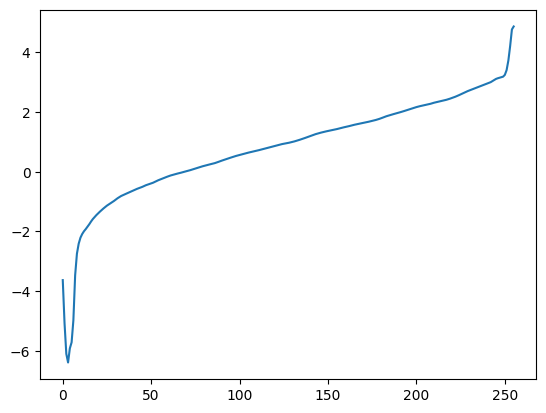

In [22]:
gaus_g= get_linearize("gaus")
plt.plot(gaus_g)
plt.show()

<ipython-input-7-d09499a4bd5b>:41: RuntimeWarning: overflow encountered in scalar negative
  radiance_row[0, index] = -weights[index, 0]
<ipython-input-8-a2b1a95f6198>:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)


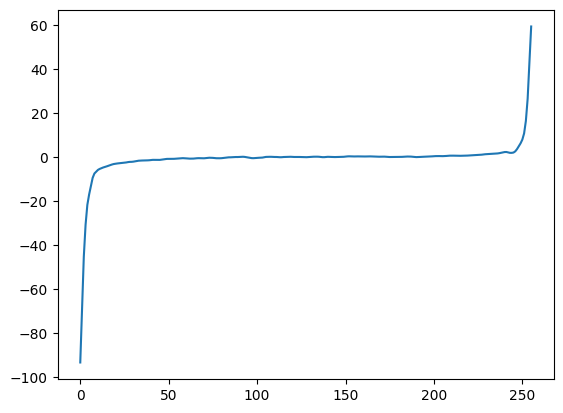

In [18]:
tent_g= get_linearize("tent")
plt.plot(tent_g)
plt.show()

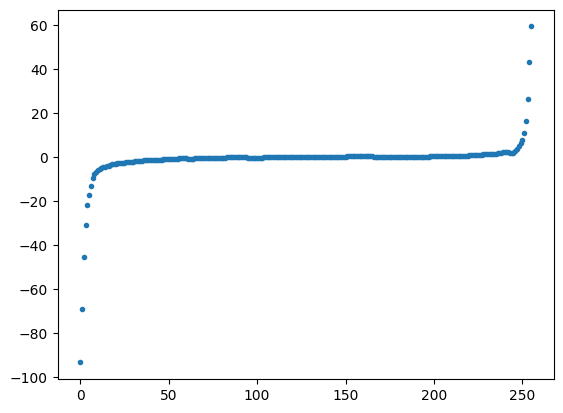

In [19]:
plt.plot(tent_g,".")
plt.show()

<ipython-input-8-a2b1a95f6198>:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)


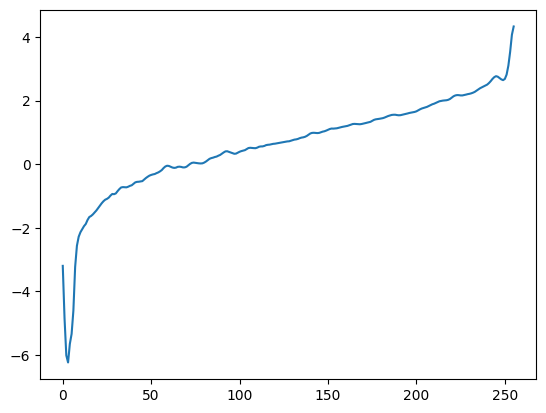

In [20]:
uniform_g= get_linearize("uniform")
plt.plot(uniform_g)
plt.show()

<ipython-input-8-a2b1a95f6198>:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)


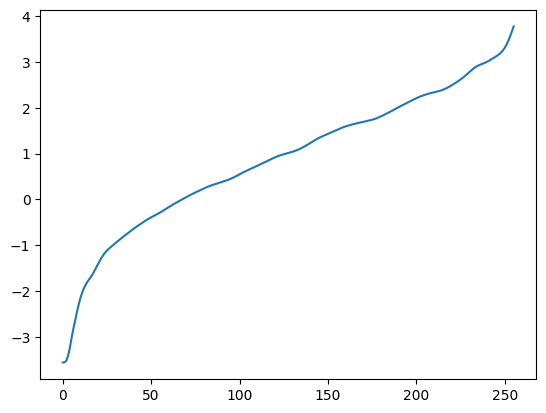

In [21]:
photon_g= get_linearize("photon")
plt.plot(photon_g)
plt.show()


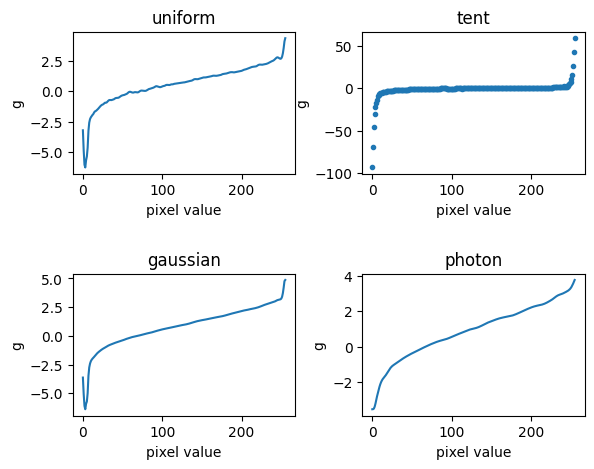

In [23]:
plt.figure("Linearized (g functions)")
plt.subplot(223), plt.title("gaussian"), plt.xlabel("pixel value"),plt.ylabel("g"),plt.plot(gaus_g)
plt.subplot(222), plt.title("tent"),plt.xlabel("pixel value"),plt.ylabel("g"), plt.plot(tent_g,".")
plt.subplot(221), plt.title("uniform"), plt.xlabel("pixel value"),plt.ylabel("g"), plt.plot(uniform_g)
plt.subplot(224), plt.title("photon"), plt.xlabel("pixel value"),plt.ylabel("g"), plt.plot(photon_g)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.7)
plt.savefig("linear.png")
plt.show()

## Merge exposure stack into HDR image

### To do that first I convert weights functions to function to not write again an again

In [10]:



# Function to assign tent weights to pixels
def tent_weights(pixels,is_linear):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.minimum(pixels, 255 - pixels)
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights = np.minimum(pixels, 1 - pixels)
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return min(pixels, 255 - pixels)
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return min(pixels, 1 - pixels)

# Function to assign Gaussian weights to pixels
def gaussian_weights(pixels,is_linear):
  """
  Assigns Gaussian weights to pixels based on their intensity values.
  """
  if isinstance(pixels, np.ndarray):
    if (is_linear):
      weights = np.exp(-4 * (pixels / 255 - 0.5)**2 / (0.5)**2) * 255
      mask_lowers = np.where(pixels < 0)
      mask_uppers = np.where(pixels > 255)
    else:
      weights = np.exp(-4 * (pixels / 1 - 0.5)**2 / (0.5)**2) * 1
      mask_lowers = np.where(pixels < 0.05)
      mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
    return weights
  else:
    if (is_linear):
      if pixels < 0 or pixels > 255:
        return 0
      else:
        return np.exp(-4 * (pixels / 255 - 0.5)**2 / (0.5)**2) * 255
    else:
      if pixels < 0.05 or pixels > 0.95:
        return 0
      else:
        return np.exp(-4 * (pixels / 1 - 0.5)**2 / (0.5)**2) * 1

# Function to assign uniform weights to pixels
def uniform_weights(pixels,is_linear):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.ones(pixels.shape) * 255
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights = np.ones(pixels.shape)
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return 255
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return 1      

# Function to assign Photon weights to pixels
def photon_weights(pixels,is_linear,exposure):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.ones(pixels.shape) * exposure * 255
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights =  np.ones(pixels.shape) * exposure * 1
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return 255
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return 1    

## Now merge function and saving to HDR Results

In [11]:
def mrg_to_hdr(is_linear,method,picture_type,weight_function):
  num = 0
  denom = 0
  if picture_type == ".tiff":
    #'2^16-1
    normalize_factor=65535
  if picture_type == ".jpg":
    normalize_factor=255
  for k in range(16):
      ldr_image=io.imread("./door_stack/exposure" + str(k + 1) + picture_type)
      if picture_type == ".tiff":
          lin_image = io.imread("./door_stack/exposure" + str(k + 1) + picture_type)
      elif picture_type == ".jpg":
          lin_image = np.exp(weight_function[ldr_image])
      exposure = (1 / 2048) * np.exp2(k)
      # ldr_Weights
      pixels = ldr_image / normalize_factor
      if (method == "gaus"):
          weights = gaussian_weights(pixels,True)
      elif (method == "tent"):
          weights = tent_weights(pixels,True)
      elif (method == "uniform"):
          weights = uniform_weights(pixels,True)
      else:
          weights = photon_weights(pixels,True,exposure)

      if is_linear:
          num += weights * lin_image / exposure 
      else:
          num += weights * (np.log(lin_image + 0.0001) - np.log(exposure))
      denom += weights
  
  mask_zeros = denom == 0
  mask_lowers = np.logical_and(mask_zeros, ldr_image < 128)
  mask_uppers = np.logical_and(mask_zeros, ldr_image > 128)
  
  denom[mask_zeros] = 1
  if is_linear:
      final_hdr = num / denom
  else:
      final_hdr = np.exp(num / denom)
  final_hdr[mask_lowers] = np.min(final_hdr)
  final_hdr[mask_uppers] = np.max(final_hdr)
  return final_hdr

In [12]:
is_linear = True
not_linear = False

In [14]:
is_linear = True
not_linear = False

### Saving Part Takes too much time don't run

In [48]:
#Gaussion  tiff
gaus_t_lin_hdr=mrg_to_hdr(is_linear,"gaus",".tiff",gaus_g)
writeHDR("./16_merge/gaus_t_lin_hdr.hdr",gaus_t_lin_hdr)
gaus_t_log_hdr=mrg_to_hdr(not_linear,"gaus", ".tiff",gaus_g)
writeHDR("./16_merge/gaus_t_log_hdr.hdr",gaus_t_log_hdr)

<ipython-input-25-a2b1a95f6198>:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_func = np.linalg.lstsq(A, b)[0][:256].reshape(-1)


In [51]:
#Gaussion  jpeg
gaus_j_lin_hdr=mrg_to_hdr(is_linear,"gaus",".jpg",gaus_g)
writeHDR("./16_merge/gaus_j_lin_hdr.hdr",gaus_j_lin_hdr)
gaus_j_log_hdr=mrg_to_hdr(not_linear,"gaus", ".jpg",gaus_g)
writeHDR("./16_merge/gaus_j_log_hdr.hdr",gaus_j_log_hdr)

In [52]:
#tent  tiff
tent_t_lin_hdr=mrg_to_hdr(is_linear,"tent",".tiff",tent_g)
writeHDR("./16_merge/tent_t_lin_hdr.hdr",tent_t_lin_hdr)
tent_t_log_hdr=mrg_to_hdr(not_linear,"tent", ".tiff",tent_g)
writeHDR("./16_merge/tent_t_log_hdr.hdr",tent_t_log_hdr)

In [53]:
#tent  jpeg
tent_j_lin_hdr=mrg_to_hdr(is_linear,"tent",".jpg",tent_g)
writeHDR("./16_merge/tent_j_lin_hdr.hdr",tent_j_lin_hdr)
tent_j_log_hdr=mrg_to_hdr(not_linear,"tent", ".jpg",tent_g)
writeHDR("./16_merge/tent_j_log_hdr.hdr",tent_j_log_hdr)

In [54]:
#Uniform  tiff
uniform_t_lin_hdr=mrg_to_hdr(is_linear,"uniform",".tiff",uniform_g)
writeHDR("./16_merge/uniform_t_lin_hdr.hdr",uniform_t_lin_hdr)
uniform_t_log_hdr=mrg_to_hdr(not_linear,"uniform", ".tiff",uniform_g)
writeHDR("./16_merge/uniform_t_log_hdr.hdr",uniform_t_log_hdr)

In [55]:
#Uniform  jpeg
uniform_j_lin_hdr=mrg_to_hdr(is_linear,"uniform",".jpg",uniform_g)
writeHDR("./16_merge/uniform_j_lin_hdr.hdr",uniform_j_lin_hdr)


In [24]:
uniform_j_log_hdr=mrg_to_hdr(not_linear,"uniform", ".jpg",uniform_g)
writeHDR("./16_merge/uniform_j_log_hdr.hdr",uniform_j_log_hdr)

In [25]:
#photon  tiff
photon_t_lin_hdr=mrg_to_hdr(is_linear,"photon",".tiff",photon_g)
writeHDR("./16_merge/photon _t_lin_hdr.hdr",photon_t_lin_hdr)
photon_t_log_hdr=mrg_to_hdr(not_linear,"photon", ".tiff",photon_g)
writeHDR("./16_merge/photon_t_log_hdr.hdr",photon_t_log_hdr)

In [26]:
#photon  jpeg
photon_j_lin_hdr=mrg_to_hdr(is_linear,"photon",".jpg",photon_g)
writeHDR("./16_merge/uniform_j_lin_hdr.hdr",photon_j_lin_hdr)

In [27]:
photon_j_log_hdr=mrg_to_hdr(not_linear,"photon",".jpg",photon_g)
writeHDR("./16_merge/photon_j_log_hdr.hdr",photon_j_log_hdr)

In [26]:
# Function to assign Photon weights to pixels
def photon_weights(pixels,is_linear,exposure):
    """
    Assigns uniform weights to pixels based on their intensity values.
    """
    if isinstance(pixels, np.ndarray):
      if (is_linear):
        weights = np.ones(pixels.shape) * exposure * 255
        mask_lowers = np.where(pixels < 0)
        mask_uppers = np.where(pixels > 255)
      else:
        weights =  np.ones(pixels.shape) * exposure * 1
        mask_lowers = np.where(pixels < 0.05)
        mask_uppers = np.where(pixels > 0.95)

      weights[mask_lowers] = 0
      weights[mask_uppers] = 0
      return weights
    else:
      if (is_linear):
        if pixels < 0 or pixels > 255:
          return 0
        else:
          return 255
      else:
        if pixels < 0.05 or pixels > 0.95:
          return 0
        else:
          return 1 

In [27]:
## Chosen one test for differnt zmin zmax values
#photon  tiff
photon_t_lin_hdr=mrg_to_hdr(is_linear,"photon",".tiff","")
writeHDR("./16_merge/photon_t_lin_hdr.hdr",photon_t_lin_hdr)

## Color Correction and White Balance

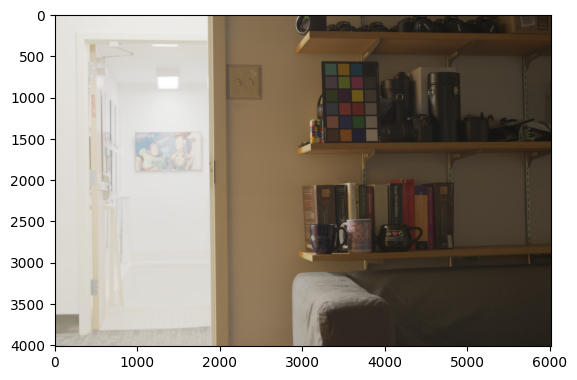

In [20]:
hdr_original = readHDR("./16_merge/photon_t_lin_hdr.hdr")
image_hdr = np.clip(hdr_original, 0, None)
tone_map_orignal = tone_mapping(hdr_original,"RGB")
plt.imshow(tone_map_orignal)
plt.show()

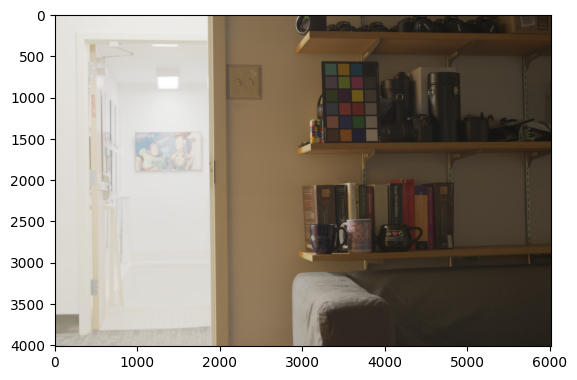

<Figure size 640x480 with 0 Axes>

In [56]:
plt.imshow(tone_map_orignal)
plt.show()
points=plt.ginput(n = 24, timeout = 41) 

### Storing points 

In [21]:
points = [(3368.7350874131303, 1462.9826299170627),
        (3514.763103507122, 1472.1093809229374),
        (3680.5657467805086, 1476.6727564258745),
        (3829.6360132097925, 1472.1093809229374),
        (3358.08721123961, 1315.433488655425),
        (3519.3264790100593, 1316.9546138230708),
        (3680.5657467805086, 1315.433488655425),
        (3831.157138377438, 1310.8701131524879),
        (3362.650586742547, 1155.7153460526213),
        (3507.157477668893, 1155.7153460526213),
        (3674.481246109926, 1149.6308453820384),
        (3826.5937628745005, 1152.67309571733),
        (3352.002710569027, 992.954953114526),
        (3508.678602836539, 991.4338279468803),
        (3666.875620271697, 997.5183286174633),
        (3811.382511198043, 994.4760782821718),
        (3345.918209898444, 831.7156853440765),
        (3496.5096014953733, 837.8001860146595),
        (3663.8333699364057, 839.3213111823053),
        (3809.8613860303976, 836.2790608470139),
        (3345.918209898444, 662.8707917353984),
        (3490.42510082479, 673.5186679089186),
        (3639.4953672540737, 673.5186679089186),
        (3799.213509856877, 670.476417573627)]

In [22]:
def color_correct_white_bal(points,image):
  #Avarage RGB
  # Define the size of the cropped square for each patch
  patch_size = 8

  # Define an empty list to store the cropped patches
  patches = []

  # Loop over each patch of the color checker
  for i in range(24):
      # Get the (x, y) coordinates of the patch in the image using matplotlib's ginput function
      coords = np.round(np.array(points[i])).astype(int)

      # Crop a square from the image that is fully contained within the patch
      patch = image[coords[1]-patch_size//2:coords[1]+patch_size//2,
                      coords[0]-patch_size//2:coords[0]+patch_size//2, :]

      # Store the patch in the list
      patches.append(patch)

  # Compute the average RGB coordinates for each patch
  avg_rgb = np.mean(patches, axis=(1, 2))
  avg_rgb = np.reshape(avg_rgb, (6, 4, 3)).transpose(1, 0, 2)
  r, g, b = read_colorchecker_gm()
  D65_color = np.dstack([r, g, b])

  # Expand with ones
  A_matrix = avg_rgb.transpose(1, 0, 2).reshape(-1, 3)
  b_vector = D65_color.transpose(1, 0, 2).reshape(-1, 3)
  ## Create ones
  ones = np.ones((A_matrix.shape[0], 1))
  ## Expand with ones
  A_matrix = np.hstack((A_matrix,ones))

  ## Transmatrix
  trans_matrix,_,_,_ = np.linalg.lstsq(A_matrix, b_vector) 

  ## Apply Transmatrix
  color_corrected = np.zeros(image.shape)
  image = np.dstack((image, np.ones((image.shape[0], image.shape[1], 1))))
  size_check = color_corrected.shape[1]
  for i in range(size_check):
      first_matrix = image[:, i, :].reshape(image.shape[0], image.shape[2])
      second_matrix = trans_matrix
      color_corrected[:, i, :] = np.matmul(first_matrix, second_matrix)

  ## Apply white balance
  # Get the (x, y) coordinates of the patch in the image using matplotlib's ginput function
  coords = np.round(np.array(points[3])).astype(int)
  # Crop a square from the image that is fully contained within the patch
  patch = np.mean(color_corrected[coords[1]-patch_size//2:coords[1]+patch_size//2,
                  coords[0]-patch_size//2:coords[0]+patch_size//2, :],axis=0)
  patch4=np.mean(patch,axis=0)
  print(patch4)
  d65_patch4 = b_vector[3] 
  print(d65_patch4)
  factor = d65_patch4  / patch4
  print(factor)
  color_corrected = color_corrected * factor
  return color_corrected

### 1. Avarage RGB

In [23]:
# Define the size of the cropped square for each patch
patch_size = 8

# Define an empty list to store the cropped patches
patches = []

# Loop over each patch of the color checker
for i in range(24):
    # Get the (x, y) coordinates of the patch in the image using matplotlib's ginput function
    coords = np.round(np.array(points[i])).astype(int)

    # Crop a square from the image that is fully contained within the patch
    patch = image_hdr[coords[1]-patch_size//2:coords[1]+patch_size//2,
                    coords[0]-patch_size//2:coords[0]+patch_size//2, :]

    # Store the patch in the list
    patches.append(patch)

# Compute the average RGB coordinates for each patch
avg_rgb = np.mean(patches, axis=(1, 2))
avg_rgb = np.reshape(avg_rgb, (6, 4, 3)).transpose(1, 0, 2)

In [24]:
r, g, b = read_colorchecker_gm()
D65_color = np.dstack([r, g, b])

### 2. Expanded with 1

In [25]:
A_matrix = avg_rgb.transpose(1, 0, 2).reshape(-1, 3)
b_vector = D65_color.transpose(1, 0, 2).reshape(-1, 3)
## Create ones
ones = np.ones((A_matrix.shape[0], 1))
## Expand with ones
A_matrix = np.hstack((A_matrix,ones))

### 3. Least Square  Transform Matrix

In [26]:
trans_matrix,_,_,_ = np.linalg.lstsq(A_matrix, b_vector)
trans_matrix

<ipython-input-26-b3fdb50ce108>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  trans_matrix,_,_,_ = np.linalg.lstsq(A_matrix, b_vector)


array([[ 8.25255489e-04, -6.74768718e-05,  7.49584310e-06],
       [ 1.61161358e-04,  1.03935951e-03, -4.58249447e-05],
       [-1.54183397e-04,  2.63112366e-04,  1.44926919e-03],
       [-7.82300080e-02, -1.01005894e-01, -1.06329087e-01]])

### 4. Apply Transform Matrix

In [27]:
color_corrected = np.zeros(image_hdr.shape)
image_hdr = np.dstack((image_hdr, np.ones((image_hdr.shape[0], image_hdr.shape[1], 1))))
size_check = color_corrected.shape[1]
print(size_check)
for i in range(size_check):
    first_matrix = image_hdr[:, i, :].reshape(image_hdr.shape[0], image_hdr.shape[2])
    second_matrix = trans_matrix
    color_corrected[:, i, :] = np.matmul(first_matrix, second_matrix)

6016


In [28]:
# Display the corrected image
#plt.imshow(color_corrected)
#plt.show


### 5. White Balance 

In [30]:
# Get the (x, y) coordinates of the patch in the image using matplotlib's ginput function
coords = np.round(np.array(points[3])).astype(int)
# Crop a square from the image that is fully contained within the patch
patch = np.mean(color_corrected[coords[1]-patch_size//2:coords[1]+patch_size//2,
                coords[0]-patch_size//2:coords[0]+patch_size//2, :],axis=0)
patch4=np.mean(patch,axis=0)
d65_patch4 = b_vector[3] 
factor = d65_patch4  / patch4
color_corrected = color_corrected * factor
writeHDR("./color_correct/Color_corrected_w_t.hdr",Color_corrected_wb)

<function matplotlib.pyplot.show(close=None, block=None)>

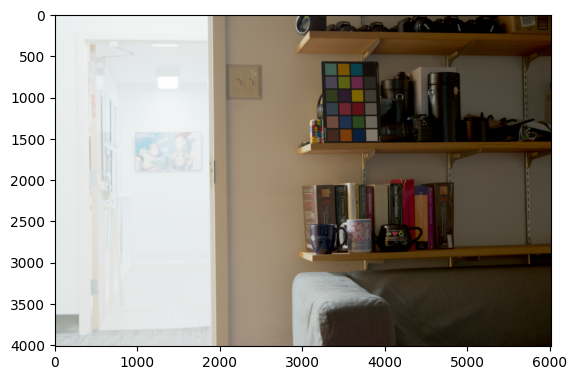

In [20]:
Color_corrected_wb = tone_mapping(color_corrected,"RGB")
writeHDR("./color_correct/Color_corrected_wb.hdr",Color_corrected_wb)
plt.imshow(Color_corrected_wb)
plt.show

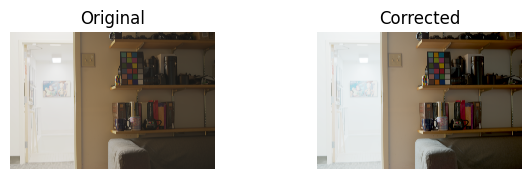

In [35]:
plt.figure("Comparison Original vs Collor Correction")
plt.subplot(121), plt.title("Original"), plt.imshow(tone_map_orignal), plt.axis('off')
plt.subplot(122), plt.title("Corrected"),plt.imshow(Color_corrected_wb), plt.axis('off')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.3)
plt.savefig("Comparison.png")
plt.show()

## Tone Mapping

In [4]:
def tone_mapping(in_image, Apply_Channel, K = 0.15, B = 0.95) :

    tonemap = np.zeros(np.shape(in_image))
    in_image = np.clip(in_image, 0, None)

    if Apply_Channel == 'RGB':
        tonemapp = np.zeros(np.shape(in_image))
        HDR = np.exp(np.mean(np.log(in_image + 0.0001)))
        #Reinhard_Formula
        for channel in range(3):
            #Equation 9
            I_hdr = (K / HDR) * in_image[:, :, channel]
            #Equation 8
            I_white = B * np.max(I_hdr)
            #iterate
            final_channel= (I_hdr * (1 + I_hdr / (I_white * I_white))) / (1 + I_hdr)
            tonemap[:, :, channel]=final_channel
        return gamma_encoding(tonemap)
    elif Apply_Channel == 'Y':
        XYZ = lRGB2XYZ(in_image)
        chnl1 = XYZ[:, :, 0] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
        chnl2 = XYZ[:, :, 1] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
        in_image = XYZ[:, :, 1]
        HDR = np.exp(np.mean(np.log(in_image + 0.0001)))
        #Equation 9
        I_hdr = (K / HDR) * in_image
        #Equation 8
        I_white = B * np.max(I_hdr)
        tonemap = (I_hdr * (1 + I_hdr / (I_white * I_white))) / (1 + I_hdr)
        Y_channel = tonemap
        X, Y, Z = xyY_to_XYZ(chnl1, chnl2, tonemap)
        RGB = XYZ2lRGB(np.dstack((X, Y, Z)))
        return gamma_encoding(RGB)

In [5]:
def gamma_encoding(RGB) :
    RGB = copy.copy(RGB)
    chnl_1 = RGB[:,:,0]
    chnl_2 = RGB[:,:,1]
    chnl_3 = RGB[:,:,2]

    mask_lower_red = RGB[:, :, 0] < 0.0031308
    mask_lower_green = RGB[:, :, 1] < 0.0031308
    mask_lower_blue = RGB[:, :, 2] < 0.0031308

    mask_upper_red  = RGB[:, :, 0] >= 0.0031308
    mask_upper_green  = RGB[:, :, 1] >= 0.0031308
    mask_upper_blue  = RGB[:, :, 2] >= 0.0031308



    chnl_1[mask_lower_red] *= 12.92 
    chnl_2[mask_lower_green] *= 12.92 
    chnl_3[mask_lower_blue] *= 12.92 

    chnl_1[mask_upper_red] = (1 + 0.055) * (chnl_1[mask_upper_red]) ** (1 / 2.4) - 0.055
    chnl_2[mask_upper_green] = (1 + 0.055) * (chnl_2[mask_upper_green]) ** (1 / 2.4) - 0.055
    chnl_3[mask_upper_blue] = (1 + 0.055) * (chnl_3[mask_upper_blue]) ** (1/2.4) - 0.055

    return  np.dstack((chnl_1, chnl_2, chnl_3))

In [5]:
Color_corrected_wb = readHDR("./color_correct/Color_corrected_wb.hdr")

<ipython-input-10-1757b967d39c>:856: RuntimeWarning: invalid value encountered in divide
  chnl1 = XYZ[:, :, 0] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
<ipython-input-10-1757b967d39c>:857: RuntimeWarning: invalid value encountered in divide
  chnl2 = XYZ[:, :, 1] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])


<Figure size 640x480 with 0 Axes>

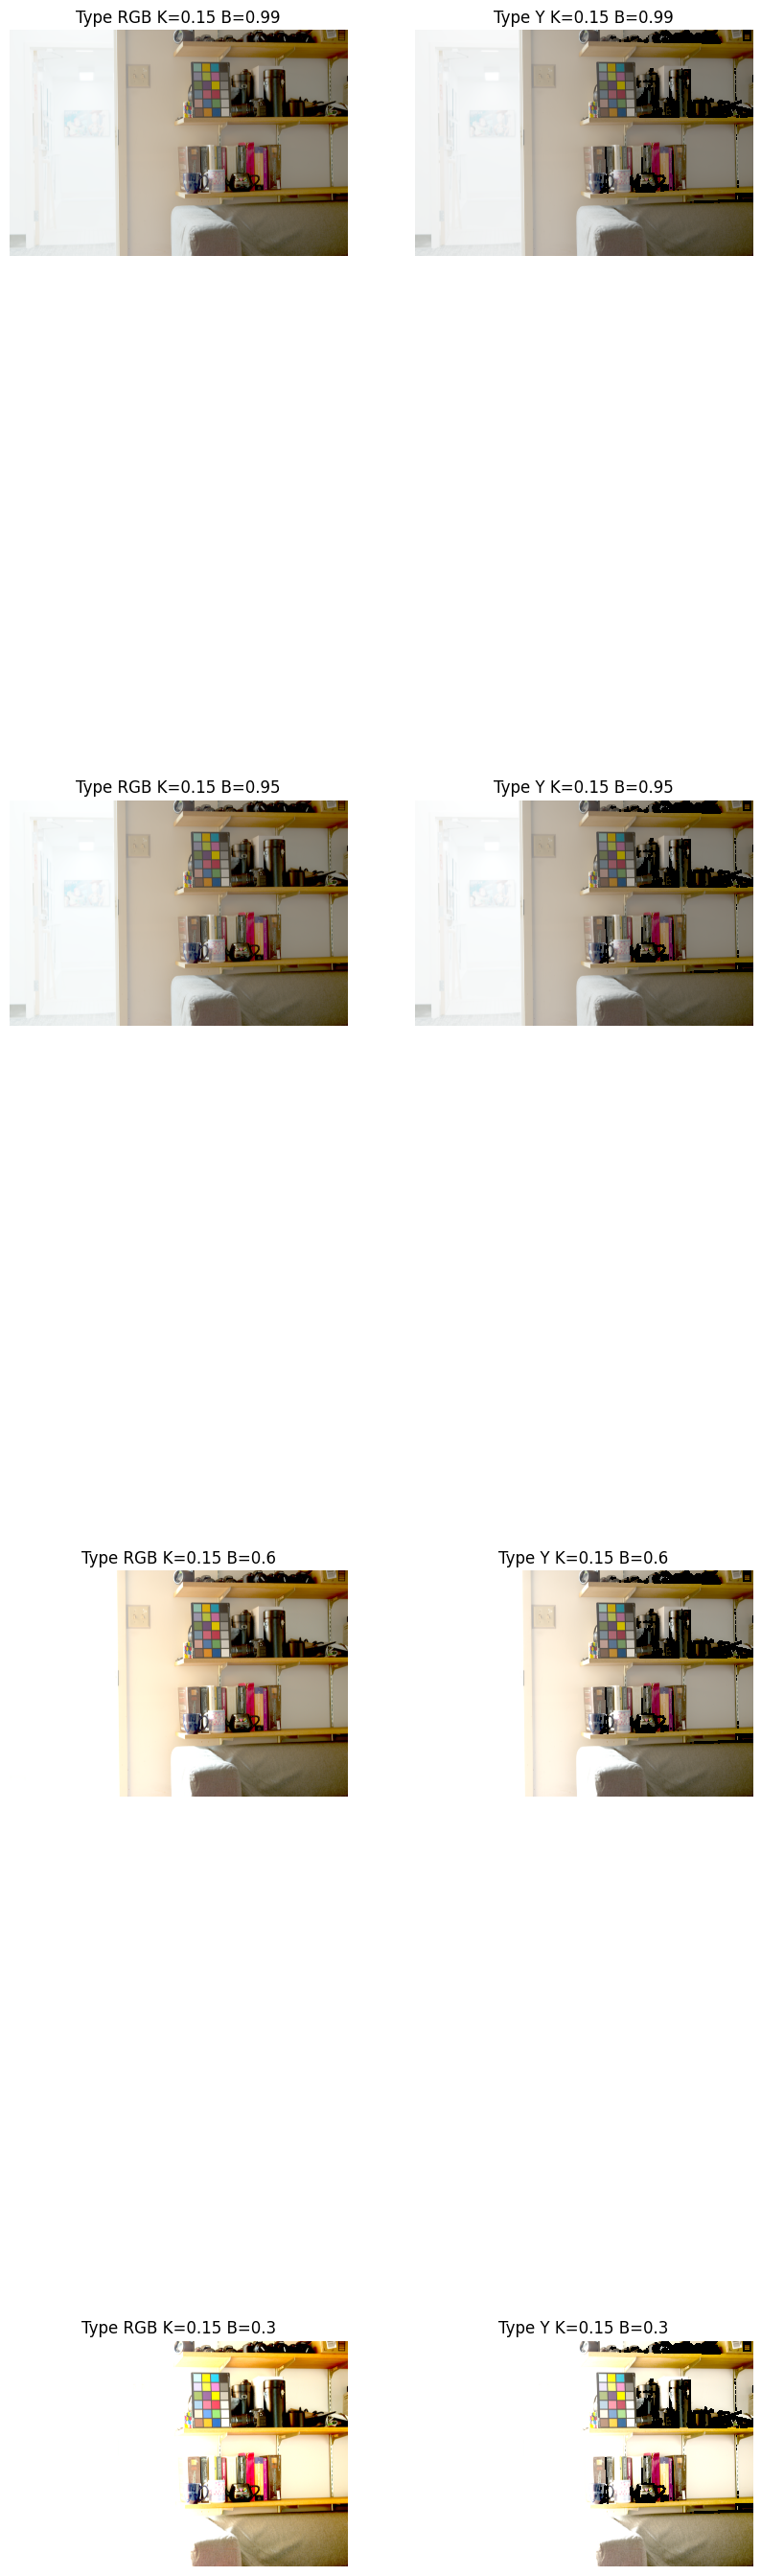

In [12]:

# change B at K=0.15
plt.figure("Tone Maping varius K=0.15 and B values")
num = 0
fig, axs = plt.subplots(nrows=4, ncols=2)
b = -1
for B in [0.99,0.95,0.60,0.30]:
    b += 1
    RGB = tone_mapping(Color_corrected_wb,"RGB", 0.15, B)
    axs[b, 0].set_title("Type RGB" + " K=0.15"+ " B=" + str(B))
    axs[b, 0].imshow(RGB)
    axs[b, 0].axis('off')
    Y = tone_mapping(Color_corrected_wb,"Y", 0.15, B)
    axs[b, 1].set_title("Type Y" + " K=0.15" + " B=" + str(B))
    axs[b, 1].imshow(Y)
    axs[b, 1].axis('off')


fig.savefig("part4_k=0.15.png")
fig.show()



<ipython-input-4-1757b967d39c>:856: RuntimeWarning: invalid value encountered in divide
  chnl1 = XYZ[:, :, 0] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
<ipython-input-4-1757b967d39c>:857: RuntimeWarning: invalid value encountered in divide
  chnl2 = XYZ[:, :, 1] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
/usr/local/lib/python3.9/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


<Figure size 640x480 with 0 Axes>

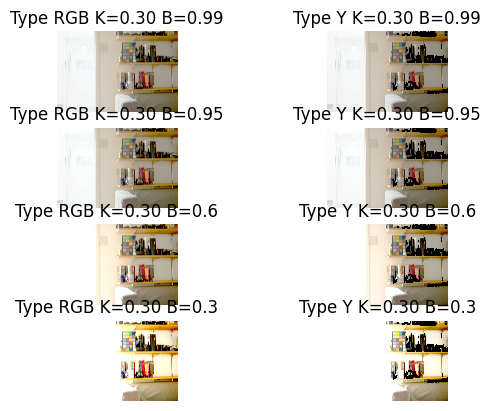

In [6]:
Color_corrected_wb = readHDR("./color_correct/Color_corrected_wb.hdr")
# change B at K=0.30
plt.figure("Tone Maping varius K=0.30 and B values")
num = 0
fig, axs = plt.subplots(nrows=4, ncols=2)
b = -1
for B in [0.99,0.95,0.60,0.30]:
    b += 1
    RGB = tone_mapping(Color_corrected_wb,"RGB", 0.30, B)
    axs[b, 0].set_title("Type RGB" + " K=0.30"+ " B=" + str(B))
    axs[b, 0].imshow(RGB)
    axs[b, 0].axis('off')
    Y = tone_mapping(Color_corrected_wb,"Y", 0.30, B)
    axs[b, 1].set_title("Type Y" + " K=0.30" + " B=" + str(B))
    axs[b, 1].imshow(Y)
    axs[b, 1].axis('off')


fig.savefig("part4_k=0.30.png")
fig.tight_layout()
fig.show()

<ipython-input-4-1757b967d39c>:856: RuntimeWarning: invalid value encountered in divide
  chnl1 = XYZ[:, :, 0] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])
<ipython-input-4-1757b967d39c>:857: RuntimeWarning: invalid value encountered in divide
  chnl2 = XYZ[:, :, 1] / (XYZ[:, :, 0] + XYZ[:, :, 1] + XYZ[:, :, 2])


<Figure size 640x480 with 0 Axes>

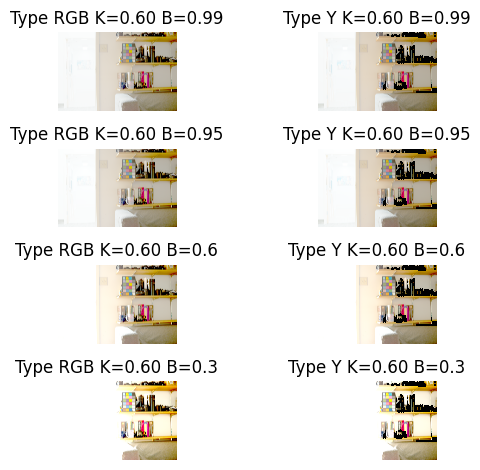

In [7]:
Color_corrected_wb = readHDR("./color_correct/Color_corrected_wb.hdr")
# change B at K=0.30
plt.figure("Tone Maping varius K=0.60 and B values")
num = 0
fig, axs = plt.subplots(nrows=4, ncols=2)
b = -1
for B in [0.99,0.95,0.60,0.30]:
    b += 1
    RGB = tone_mapping(Color_corrected_wb,"RGB", 0.60, B)
    axs[b, 0].set_title("Type RGB" + " K=0.60"+ " B=" + str(B))
    axs[b, 0].imshow(RGB)
    axs[b, 0].axis('off')
    Y = tone_mapping(Color_corrected_wb,"Y", 0.60, B)
    axs[b, 1].set_title("Type Y" + " K=0.60" + " B=" + str(B))
    axs[b, 1].imshow(Y)
    axs[b, 1].axis('off')


fig.savefig("part4_k=0.60.png")
fig.tight_layout()
fig.show()

In [5]:
Color_corrected_wb = readHDR("./color_correct/Color_corrected_wb.hdr")

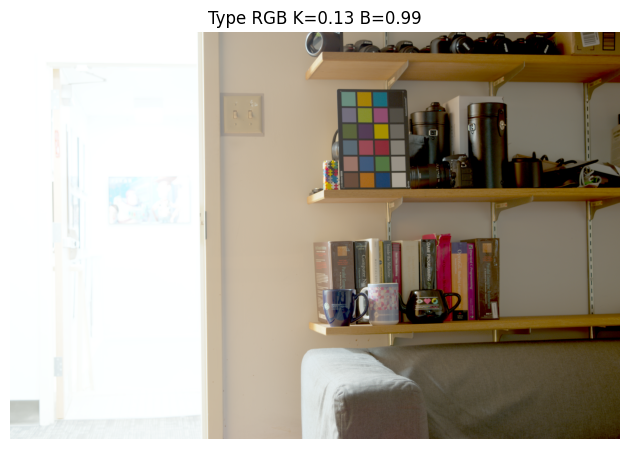

In [11]:
# change B at K=0.30
plt.figure("Tone Maping varius K=0.08nd B values")

RGB = tone_mapping(Color_corrected_wb,"RGB", 0.08, 0.90)
plt.title("Type RGB" + " K=0.13"+ " B=0.99")
plt.imshow(RGB)
plt.axis('off')
plt.tight_layout()

plt.savefig("part4_k=0.13.png")

plt.show()

In [ ]:
def white_balance(img, ref_patch, ref_value):
    # Convert image to float32 and split channels
    img = img.astype(np.float32)
    b, g, r = cv2.split(img)

    # Calculate average value of reference patch
    ref_avg = np.mean(ref_patch)

    # Calculate scaling factor for each channel
    b_factor = ref_value[0] / ref_avg
    g_factor = ref_value[1] / ref_avg
    r_factor = ref_value[2] / ref_avg

    # Apply scaling factor to each channel
    b = cv2.multiply(b, b_factor)
    g = cv2.multiply(g, g_factor)
    r = cv2.multiply(r, r_factor)

    # Merge channels and clamp values
    img = cv2.merge([b, g, r])
    img = np.clip(img, 0, 255)

    # Convert back to uint8
    img = img.astype(np.uint8)

    return img

In [ ]:
def mrg_to_hdr_tiff(is_linear,method):
    num = 0
    denom = 0
    for k in range(16):
        ldr_image=io.imread("./door_stack/exposure" + str(k + 1) + ".tiff")
        lin_image = io.imread("./door_stack/exposure" + str(k + 1) + ".tiff")
        exposure = (1 / 2048) * np.exp2(k)
        # ldr_Weights  
        # divde to 2^16 -1
        pixels = ldr_image / (65535)
        if (method == "gaus"):
            weights = gaussian_weights(pixels,True)
        elif (method == "tent"):
            weights = tent_weights(pixels,True)
        elif (method == "uniform"):
            weights = uniform_weights(pixels,True)
        else:
            weights = photon_weights(pixels,True,exposure)

        if is_linear:
            num += weights * lin_image / exposure 
        else:
            num += weights * (np.log(lin_image + 0.0001) - np.log(exposure))
        denom += weights
    
    mask_zeros = denom == 0
    denom[mask_zeros] = 1

    if is_linear:
        final_hdr = num / denom
    else:
        final_hdr = np.exp(num / denom)

    final_hdr = np.clip(final_hdr, np.min(final_hdr), np.max(final_hdr))
    return final_hdr


def mrg_to_hdr_jpg(is_linear,method):

    weight_function = get_linearize(method)
    num = 0
    denom = 0
    for k in range(16):
        ldr_image=io.imread("./door_stack/exposure" + str(k + 1) + ".jpg")
        lin_image = np.exp(weight_function[ldr_image])
        exposure = (1 / 2048) * np.exp2(k)
        # ldr_Weights
        pixels = ldr_image / 255
        if (method == "gaus"):
            weights = gaussian_weights(pixels,True)
        elif (method == "tent"):
            weights = tent_weights(pixels,True)
        elif (method == "uniform"):
            weights = uniform_weights(pixels,True)
        else:
            weights = photon_weights(pixels,True,exposure)

        if is_linear:
            num += weights * lin_image / exposure 
        else:
            num += weights * (np.log(lin_image + 0.0001) - np.log(exposure))
        denom += weights
    
    mask_zeros = denom == 0
    denom[mask_zeros] = 1

    if is_linear:
        final_hdr = num / denom
    else:
        final_hdr = np.exp(num / denom)

    final_hdr = np.clip(final_hdr, np.min(final_hdr), np.max(final_hdr))
    return final_hdr